# Import Dependencies and Pretrained Model

In [6]:
import tensorflow_hub as hub
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

# Load the Style Transfer Model

In [7]:
# Load the style transfer model
model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

# Preprocess Image and Load Content & Style Images

In [8]:
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (256, 256))  # Resize to match the model input size
    image = image[tf.newaxis, :]  # Add a batch dimension
    return image

content_image = load_image('/content/profilepic.jpg')
style_image = load_image('/content/art.png')

# Display Content and Style Images

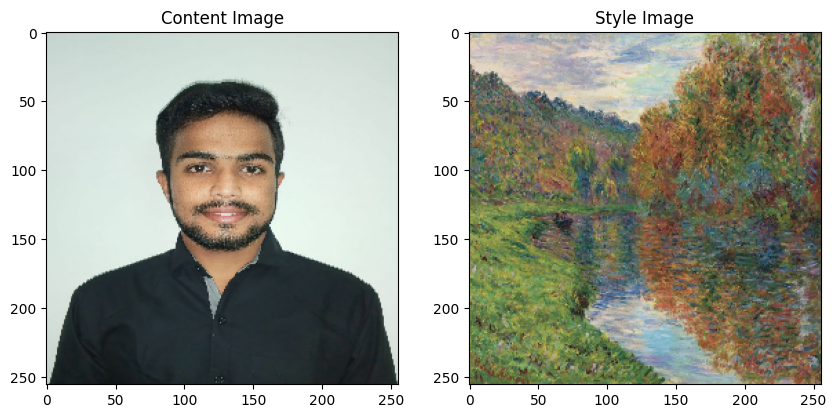

In [9]:
# Display content and style images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Content Image")
plt.imshow(np.squeeze(content_image))
plt.subplot(1, 2, 2)
plt.title("Style Image")
plt.imshow(np.squeeze(style_image))
plt.show()

# Generate Stylized Image

In [10]:
# Generate the stylized image
stylized_image = model(tf.constant(content_image), tf.constant(style_image))[0]

# Display and Save Stylized Image

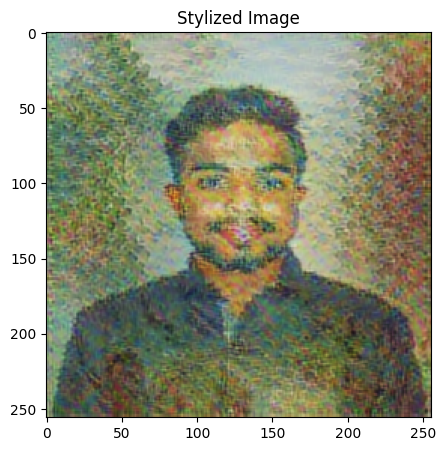

In [11]:
# Display stylized image
plt.figure(figsize=(5, 5))
plt.title("Stylized Image")
plt.imshow(np.squeeze(stylized_image))
plt.show()

In [12]:
# Save the stylized image
cv2.imwrite('generated_img.jpg', cv2.cvtColor(np.squeeze(stylized_image) * 255, cv2.COLOR_BGR2RGB))

True

# Set Up VGG19 for Perceptual Loss and Extract Content and Style Features

In [13]:
# Set up VGG19 for perceptual loss calculation
vgg = VGG19(weights='imagenet', include_top=False)
content_layers = ['block5_conv2']  # Used for content loss
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']  # Used for style loss

def get_feature_extractor(layer_names):
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = Model([vgg.input], outputs)
    model.trainable = False
    return model

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Define Content and Style Loss Calculations

In [14]:
# Extract content and style features
content_extractor = get_feature_extractor(content_layers)
style_extractor = get_feature_extractor(style_layers)

def calculate_content_loss(content, generated):
    content_features = content_extractor(content)
    generated_features = content_extractor(generated)
    return tf.reduce_mean(tf.square(content_features[0] - generated_features[0]))

def calculate_gram_matrix(features):
    # Calculate Gram matrix for style representation
    gram = tf.linalg.einsum('bijc,bijd->bcd', features, features)
    input_shape = tf.shape(features)
    return gram / tf.cast(input_shape[1] * input_shape[2] * input_shape[3], tf.float32)

def calculate_style_loss(style, generated):
    style_features = style_extractor(style)
    generated_features = style_extractor(generated)
    style_loss = 0
    for sf, gf in zip(style_features, generated_features):
        style_loss += tf.reduce_mean(tf.square(calculate_gram_matrix(sf) - calculate_gram_matrix(gf)))
    return style_loss / len(style_layers)

# Compute Initial Content and Style Loss

In [15]:
# Calculate content and style loss
content_loss = calculate_content_loss(content_image, stylized_image)
style_loss = calculate_style_loss(style_image, stylized_image)

# Display loss values
print(f"Content Loss: {content_loss.numpy():.4f}")
print(f"Style Loss: {style_loss.numpy():.4f}")

Content Loss: 0.7350
Style Loss: 0.0004


# Optimization Settings and Initializations

In [16]:
# Optimization settings
generated_image = tf.Variable(content_image)
optimizer = tf.optimizers.Adam(learning_rate=0.02)
content_weight = 1e3
style_weight = 1e-2
iterations = 100

# Training Loop for Image Optimization

In [17]:
# Lists to store loss values
content_loss_history = []
style_loss_history = []

for i in range(iterations):
    with tf.GradientTape() as tape:
        # Forward pass for loss calculation
        content_loss = calculate_content_loss(content_image, generated_image)
        style_loss = calculate_style_loss(style_image, generated_image)
        total_loss = content_weight * content_loss + style_weight * style_loss

    # Apply gradients to update the generated image
    grads = tape.gradient(total_loss, generated_image)
    optimizer.apply_gradients([(grads, generated_image)])
    generated_image.assign(tf.clip_by_value(generated_image, 0.0, 1.0))

    # Record loss values
    content_loss_history.append(content_loss.numpy())
    style_loss_history.append(style_loss.numpy())

    # Display progress every 20 iterations
    if (i+1) % 20 == 0:
        print(f"Iteration {i+1}/{iterations}, Content Loss: {content_loss.numpy():.4f}, Style Loss: {style_loss.numpy():.4f}")

Iteration 20/100, Content Loss: 0.0124, Style Loss: 0.0073
Iteration 40/100, Content Loss: 0.0047, Style Loss: 0.0089
Iteration 60/100, Content Loss: 0.0028, Style Loss: 0.0098
Iteration 80/100, Content Loss: 0.0025, Style Loss: 0.0104
Iteration 100/100, Content Loss: 0.0018, Style Loss: 0.0109


# Plot Content and Style Loss History

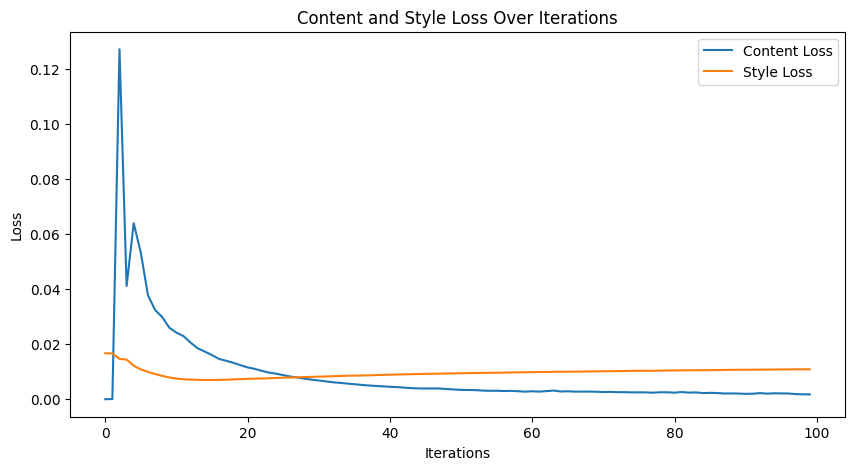

In [18]:
# Plot content and style loss history
plt.figure(figsize=(10, 5))
plt.plot(content_loss_history, label='Content Loss')
plt.plot(style_loss_history, label='Style Loss')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Content and Style Loss Over Iterations")
plt.legend()
plt.show()

# Display and Save Final Stylized Image

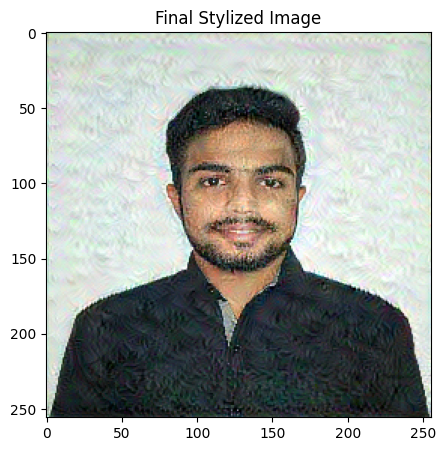

In [19]:
# Display final stylized image
plt.figure(figsize=(5, 5))
plt.title("Final Stylized Image")
plt.imshow(np.squeeze(generated_image))
plt.show()

In [20]:
# Save the final stylized image
cv2.imwrite('generated_img.jpg', cv2.cvtColor(np.squeeze(generated_image.numpy()) * 255, cv2.COLOR_BGR2RGB))

True